<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 8, style="color:rgb(200,0,0)"><b>Deep Learning</b></font></h1> 
<a href="mailto:rogerio.oliveira@mackenzie.br">Rogério de Oliveira</a><br>

<br>
<br>

---


In [1]:
%matplotlib inline


Um tutorial para redes recorrentes com PyTorch
==============================================

# Treinando redes RNN e LSTM para série de evolução de casos de COVID no Brasil


### Sumário 

Este tutorial emprega e explora os modelos RNN e LSTM para a previsão de série de dados de evolução de novos casos de Covid no Brasil obtidos do site do Ministério da Saúde. 

Aqui você verá também como enviar as variáveis e modelos para **GPU** (não, não basta setar o ambiente do seu Colab!!!).

### Resultados 

Aqui uma apresentação sumária dos resultados (esses gráficos são produzidos ao longo da execução do notebook).


In [2]:
# from IPython.display import Image, display
# display(Image('/content/plot_lstm1_4_layers.png'))
# display(Image('/content/plot_lstm2_4_layers.png'))
# display(Image('/content/plot_rnn1_4_layers.png'))

### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Aquisição e Preparação dos Dados

In [6]:
corona = pd.read_csv('http://meusite.mackenzie.br/rogerio/corona_Brasil.csv')
corona.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9.0,210147125.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9.0,210147125.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9.0,210147125.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN


In [7]:
from datetime import datetime
corona.data = pd.to_datetime(corona.data, format='%Y-%m-%d',errors='coerce')

corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   regiao                  322 non-null    object        
 1   estado                  0 non-null      float64       
 2   municipio               0 non-null      float64       
 3   coduf                   322 non-null    int64         
 4   codmun                  0 non-null      float64       
 5   codRegiaoSaude          0 non-null      float64       
 6   nomeRegiaoSaude         0 non-null      float64       
 7   data                    322 non-null    datetime64[ns]
 8   semanaEpi               322 non-null    float64       
 9   populacaoTCU2019        322 non-null    float64       
 10  casosAcumulado          322 non-null    float64       
 11  casosNovos              322 non-null    float64       
 12  obitosAcumulado         322 non-null    float64   

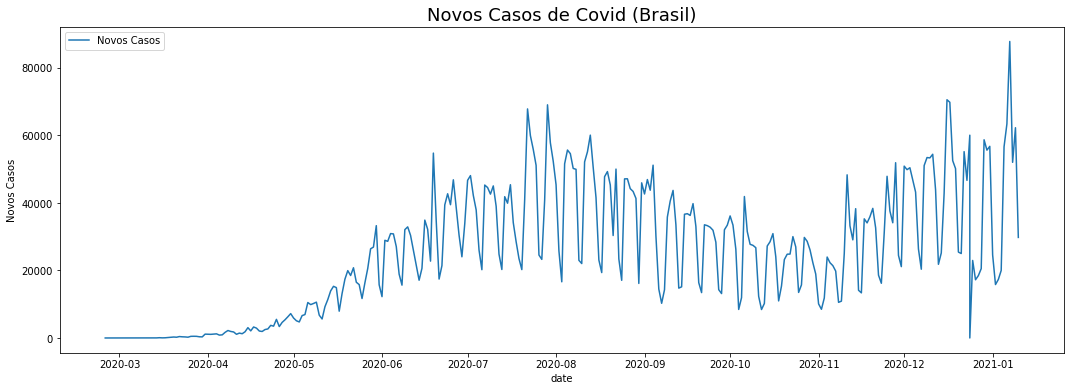

In [8]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(corona.data, corona.casosNovos, label='Novos Casos')

ax.set_title('Novos Casos de Covid (Brasil)', fontsize=18)
ax.set_xlabel("date")
ax.set_ylabel("Novos Casos")

ax.legend()

plt.show()

### Normalização

O **dados precisam ser reescalados** (normalizados) para uso nos modelos recorrentes. O treinamento falha (executa mas não faz as predições corretamente) se os dados não são reescalados e você pode verificar isso omitindo essa célula e reexecutando o notebook.

Como os dados são números de novos casos e, portanto positivos, podemos reescalar os dados simplesmente dividindo-os pelo valor máximo.

In [9]:
training_set = corona.casosNovos / corona.casosNovos.max()

# Dados para Tensores e GPU

Agora é necessário converter os dados para tensores e carregá-los no ambiente de GPU. Se estiver executando no Colab altere o tipo de Ambiente de Execução para GPU.

### Verificando o ambiente CUDA GPU

In [11]:
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(torch.cuda.current_device()))
# print(torch.cuda.is_available())

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


**Importante** Note que os dados não são automaticamente carregados na GPU. Para isso é necessário empregar `.to(device)`. Para mais detalhes ver: https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_deep-learning-computation/use-gpu.ipynb. 

Dados do aprendizado e modelo precisarão ser carregados na GPU desse modo para efetivamente empregarem esse recurso.

In [18]:
#
# Sem gpu
dados  = torch.tensor(trainining_set)
print(dados.is_cuda)

False


In [19]:
#
# # Com gpu
# dados = torch.tensor(training_set)
# dados = dados.to(device)
# print(dados.is_cuda)

Também convertemos os dados para `float`. 

In [20]:
print(dados.type())
print(dados.shape)
dados = dados.type(torch.float) 
print(dados.type())
print(dados.shape)

torch.DoubleTensor
torch.Size([322])
torch.FloatTensor
torch.Size([322])


# Definindo a Janela de Dados Temporal e os Dados de Treinamento e Teste

Aqui os dados são reorganizados nas janelas de dados temporais. Aqui empregamos uma janela de tamanho 6:

$$ x_{i}, ..., x_{i+5} \rightarrow x_{i+6} $$ 

abaixo ilustramos os conjuntos de dados reoganizados nessas janelas para o intervalo $[x_{50}, x_{58}]$. 

Os dados de treinamento e teste são separados empregando-se os 0.8 dados iniciais como treinamento e os 0.2 dados finais como teste.



### Janelas de Dados

In [31]:
dados.shape

torch.Size([322])

In [21]:
def Window(data, lenght_windows):
  lenght_data = data.shape[0]
  data_x = torch.zeros(lenght_data - lenght_windows-1, lenght_windows)
  data_y =  torch.zeros(lenght_data - lenght_windows-1)
   
  for i in range(lenght_windows):
    data_x[:,i] = data[i:lenght_data - lenght_windows -1 + i] 
  
  # Uma dimensão adicional é requerida
  data_y = data[lenght_windows:].unsqueeze(-1)
  return data_x.unsqueeze(-1), data_y 

train_size = int(len(dados) * 0.8)
test_size = len(dados) - train_size

seq_length = 6
x, y = Window(dados, seq_length)

x, y = x.to(device), y.to(device) # importante para o uso de GPU

trainX, trainY  = x[:train_size],y[:train_size]
testX, testY = x[train_size:],y[train_size:]

In [22]:
print(f'trainX: {trainX.type()} , {trainX.shape}')
print(f'trainY: {trainY.type()} , {trainY.shape}')
print(f'testX: {testX.type()} , {testX.shape}')
print(f'testY: {testY.type()} , {testY.shape}')

trainX: torch.FloatTensor , torch.Size([257, 6, 1])
trainY: torch.FloatTensor , torch.Size([257, 1])
testX: torch.FloatTensor , torch.Size([58, 6, 1])
testY: torch.FloatTensor , torch.Size([59, 1])


### Exemplo de janelas de dados

Aqui ilustramos as janelas de dados produzidas:

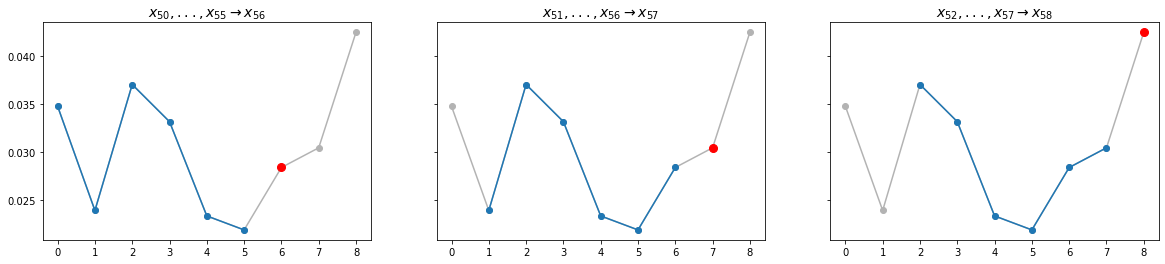

In [15]:
w_size=seq_length
min = 50
max = 53

fig, ax = plt.subplots(1, len(trainX[min:max]), figsize=(20,4), sharey=True )
for i in range(len(trainX[min:max])):
  ax[i].plot( dados[min:max + w_size].to('cpu'),marker='o',color='0.7')
  ax[i].plot(np.arange(w_size*i,w_size*i+w_size) - i*w_size + i, trainX[min:max][i].to('cpu'),marker='o')
  ax[i].plot(w_size+i,trainY[50:53][i].to('cpu'),marker='o', color='red' , markersize=8)
  ax[i].set_title(f'$x_{{{str(i + min)}}} ,..., x_{{{str(w_size + i + min - 1 )}}} \\rightarrow  x_{{{str(w_size + i + min)}}} $', fontsize=14)
plt.show()

In [16]:
dados[min:max + w_size]

tensor([0.0348, 0.0240, 0.0371, 0.0332, 0.0234, 0.0219, 0.0284, 0.0305, 0.0425],
       device='cuda:0')

In [17]:
trainX[50:53]


tensor([[[0.0348],
         [0.0240],
         [0.0371],
         [0.0332],
         [0.0234],
         [0.0219]],

        [[0.0240],
         [0.0371],
         [0.0332],
         [0.0234],
         [0.0219],
         [0.0284]],

        [[0.0371],
         [0.0332],
         [0.0234],
         [0.0219],
         [0.0284],
         [0.0305]]], device='cuda:0')

In [18]:
trainY[50:53]

tensor([[0.0284],
        [0.0305],
        [0.0425]], device='cuda:0')

### Treinamento e teste

Os dados foram separados acima. Aqui apenas ilustrando a separação efetuda.

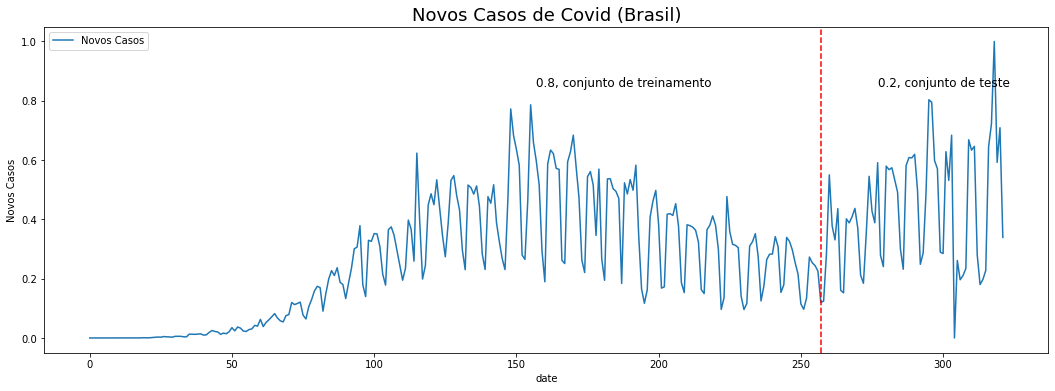

In [19]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(training_set, label='Novos Casos')
ax.axvline(x=train_size, c='r', linestyle='--')
ax.set_title('Novos Casos de Covid (Brasil)', fontsize=18)
ax.set_xlabel("date")
ax.set_ylabel("Novos Casos")

ax.text(train_size - 100, 0.85, '0.8, conjunto de treinamento', fontsize=12)
ax.text(train_size + 20, 0.85, '0.2, conjunto de teste', fontsize=12)
ax.legend()

plt.show()



# Explorando a saída de uma camada recorrente

* `input_size = 1`

Especifica quantas séries de dados serão empregadas (`TrainX`). Aqui empregamos uma única série de dados de `casosNovos`, isto é `casosNovos` $\rightarrow$ `casosNovos`. Mais adiante adicionamos uma série de dados de `obitosNovos` para estimar `casosNovos` a partir de duas séries de entrada `[casosNovos, obitosNovos]` $\rightarrow$ `casosNovos`, neste caso empregaremos mais adiante `input_size = 2`.

* `hidden_size = 6`

Aqui são as etapas para prever. Notar que a `lstm` tem duas saídas:

`out` é a saída do RNN de todos os passos de tempo da última camada RNN 
`h_n` é o valor oculto da última etapa de tempo de todas as camadas RNN

Em geral vamos empregar a última saída, mas você pode querer empregar as camadas anteriores.

* `num_layers = 2`

O número de camadas. Note que para cada camada é gerado um conjunto de saídas `y`. Para um `num_layers = 1` podemos aplicar diretamente uma camada `fc` (linear por exemplo), mas para `num_layers >= 2` haverão `num_layers` saídas, interessando somente a última camada.


Da documentação:

Outputs: `out, (h_n, c_n)`

`out (seq_len, batch, hidden_size * num_directions)`: 
tensor containing the output features (h_t) from the last layer of the RNN, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence.

`h_n (num_layers * num_directions, batch, hidden_size)`: 
tensor containing the hidden state for t=seq_len

`c_n (num_layers * num_directions, batch, hidden_size)`: 
tensor containing the cell state for t=seq_len


Podemos verificar que `out[-1]` e `h_out` ambos tem os mesmos valores como podemos observar aqui isoladamente: 

In [20]:
torch.manual_seed(0)
model = nn.LSTM( input_size = 1, hidden_size = 50, num_layers  = 1 )
xrand = torch.rand(50, 1, 1)
out, (h_out, cn) = model(xrand)

print(out[-1].view(-1))
print(h_out.view(-1))

tensor([ 0.1140, -0.0600, -0.0540,  0.1492, -0.0339, -0.0150, -0.0486,  0.0188,
         0.0504,  0.0595, -0.0176, -0.0035,  0.0384, -0.0274,  0.1076,  0.0843,
        -0.0443,  0.0218, -0.0093,  0.0002,  0.1335,  0.0926,  0.0101, -0.1300,
        -0.1141,  0.0072, -0.0142,  0.0018,  0.0071,  0.0247,  0.0262,  0.0109,
         0.0374,  0.0366,  0.0017,  0.0466,  0.0063,  0.0295,  0.0536,  0.0339,
         0.0528, -0.0305,  0.0243, -0.0324,  0.0045, -0.1108, -0.0041, -0.1043,
        -0.0141, -0.1222], grad_fn=<ViewBackward>)
tensor([ 0.1140, -0.0600, -0.0540,  0.1492, -0.0339, -0.0150, -0.0486,  0.0188,
         0.0504,  0.0595, -0.0176, -0.0035,  0.0384, -0.0274,  0.1076,  0.0843,
        -0.0443,  0.0218, -0.0093,  0.0002,  0.1335,  0.0926,  0.0101, -0.1300,
        -0.1141,  0.0072, -0.0142,  0.0018,  0.0071,  0.0247,  0.0262,  0.0109,
         0.0374,  0.0366,  0.0017,  0.0466,  0.0063,  0.0295,  0.0536,  0.0339,
         0.0528, -0.0305,  0.0243, -0.0324,  0.0045, -0.1108, -0.0041

Ou no caso específico dos dados de Covid aqui empregados:

In [21]:
input_size = 1 # Este valor não podemos alterar aqui pois trainX é uma única série de dados (mais abaixo empregaremos 2 séries de dados)
hidden_size = 5
num_layers = 2

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
lstm = lstm.to(device) # para que o modelo ou função esteja no mesmo device

print(f'\n ...com input_size = {input_size} , hidden_size = {hidden_size}, num_layers = {num_layers} as entradas e saídas da lstm são: ')
out, (h_out, cn) = lstm(trainX)
print(f'trainX: {trainX.shape}')
print(f'out: {out.shape}')
print(f'h_out: {h_out.shape}')

input_size = 1
hidden_size = 1
num_layers = 1

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
lstm = lstm.to(device) # para que o modelo ou função esteja no mesmo device dos dados

print(f'\n ...com input_size = {input_size} , hidden_size = {hidden_size}, num_layers = {num_layers} as entradas e saídas da lstm são: ')
out, (h_out, cn) = lstm(trainX)
print(f'trainX: {trainX.shape}')
print(f'out: {out.shape}')
print(f'h_out: {h_out.shape}')





 ...com input_size = 1 , hidden_size = 5, num_layers = 2 as entradas e saídas da lstm são: 
trainX: torch.Size([257, 6, 1])
out: torch.Size([257, 6, 5])
h_out: torch.Size([2, 257, 5])

 ...com input_size = 1 , hidden_size = 1, num_layers = 1 as entradas e saídas da lstm são: 
trainX: torch.Size([257, 6, 1])
out: torch.Size([257, 6, 1])
h_out: torch.Size([1, 257, 1])


In [22]:
print(out[:,-1,0].shape == h_out[0,:,0].shape)
print(sum(out[:,-1,0] != h_out[0,:,0]) == 0)

True
tensor(True, device='cuda:0')


Podemos agora aplicar uma camada `fc`(full connected) à saída da última camada (`h_out[-1]`):

In [23]:
fc = nn.Linear(hidden_size, 1)
fc = fc.to(device) # para que o modelo ou função esteja no mesmo device dos dados

last_layer = h_out[-1] 
out_final = fc(last_layer.view(-1,hidden_size))
print(out_final.shape)

torch.Size([257, 1])


**Importante**: verifique que as dimensões de `TrainY` e `out_final` do modelo precisam coincidir.

In [24]:
trainY.shape

torch.Size([257, 1])

# Rede LSTM

Como no caso das redes convolucionais definimos o modelo como uma classe Python sendo necessário somente a definição do método `forward`.

In [25]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)
     
        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)  
        out_final = self.fc(h_out)

        return out_final

### Função de Treinamento

In [26]:
def train(model, optmizer, loss_f, num_epochs, data_train_x, data_train_y):

  for epoch in range(num_epochs):
    
    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


# Treinamento com `num_layers = 1, 2, 3 e 4`

Vamos fazer o treinamento para diferentes números de camadas. O melhor resultado aqui, aparentemente é com 4 camadas.

Epoch: 0, loss: 0.49026
Epoch: 500, loss: 0.00983
Epoch: 1000, loss: 0.00678
Epoch: 1500, loss: 0.00625


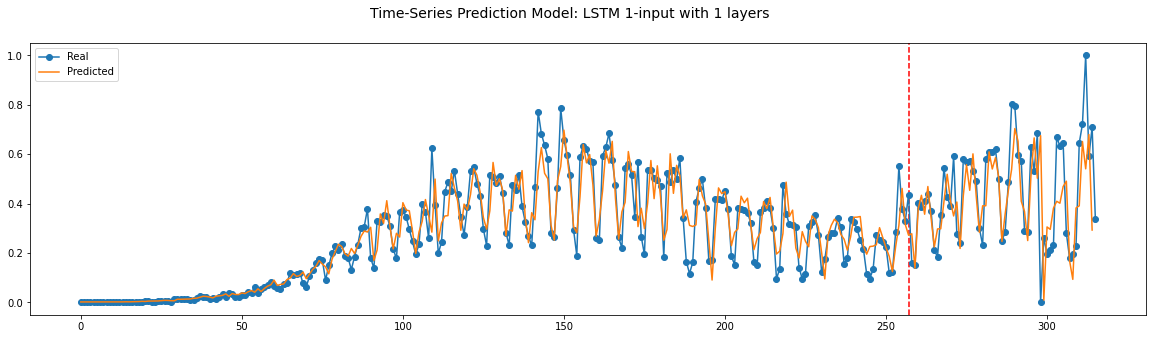

Epoch: 0, loss: 0.07393
Epoch: 500, loss: 0.00444
Epoch: 1000, loss: 0.00270
Epoch: 1500, loss: 0.00125


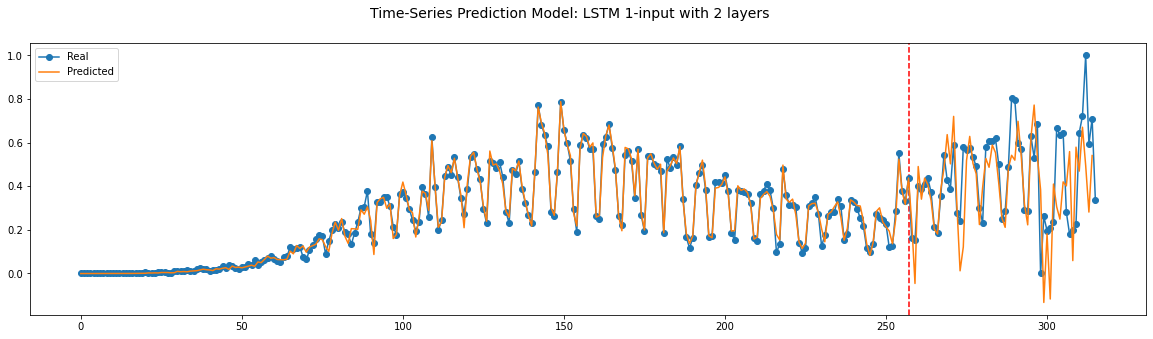

Epoch: 0, loss: 0.20700
Epoch: 500, loss: 0.00381
Epoch: 1000, loss: 0.00225
Epoch: 1500, loss: 0.00144


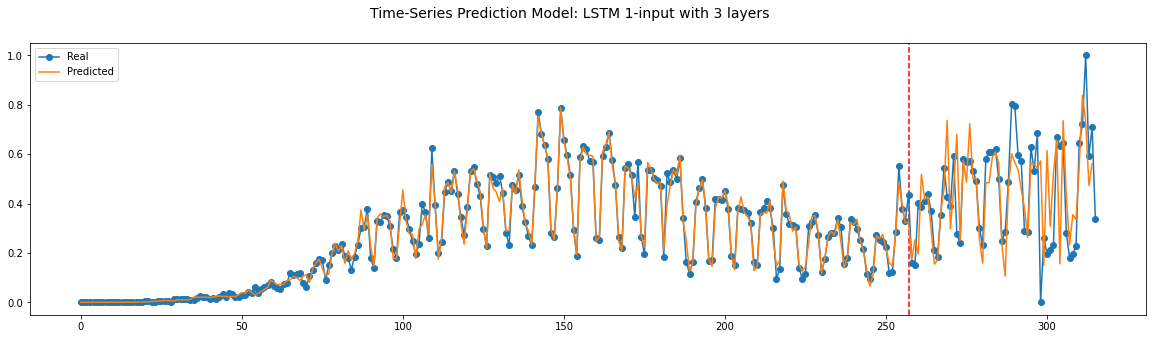

Epoch: 0, loss: 0.07061
Epoch: 500, loss: 0.00889
Epoch: 1000, loss: 0.00364
Epoch: 1500, loss: 0.00211


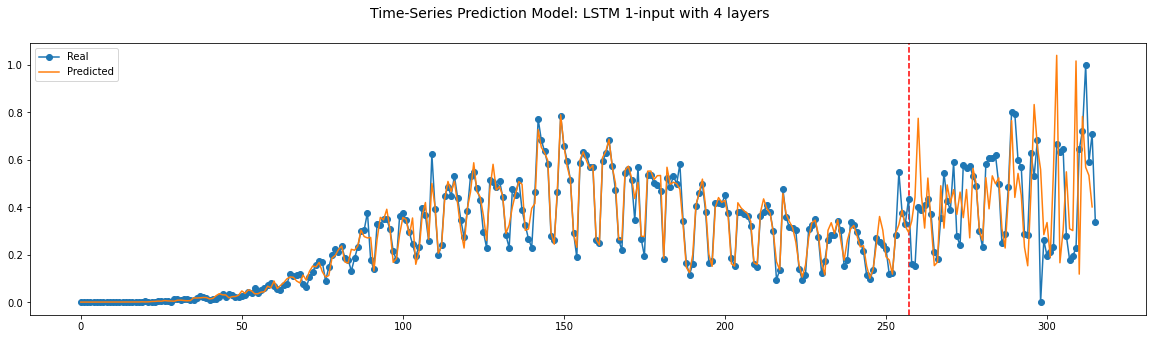

In [27]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! uma única série de dados
hidden_size = 6

for num_layers in range(1,5):

  # num_layers = 1, 2, 3, 4

  model = LSTM(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, trainX, trainY)

  model.eval()
  prediction = model(x.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: LSTM 1-input with {num_layers} layers', fontsize=14)
  
  plt.savefig('plot_lstm1_' + str(num_layers) + '_layers.png')
  plt.show()

# Adicionando uma Segunda Série de Dados

Agora vamos adicionar a série de dados de `obitosNovos` para estimar `casosNovos` a partir de duas séries de entrada `[casosNovos, obitosNovos]` $\rightarrow$ `casosNovos`, e empregaremos `input_size = 2`.


In [28]:
training_set2 = corona.obitosNovos / corona.obitosNovos.max()

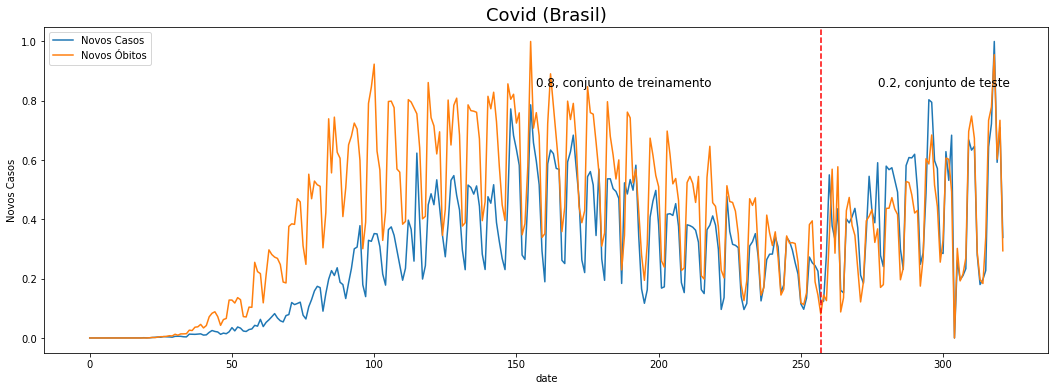

In [29]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(training_set, label='Novos Casos')
ax.plot(training_set2, label='Novos Óbitos')
ax.axvline(x=train_size, c='r', linestyle='--')
ax.set_title('Covid (Brasil)', fontsize=18)
ax.set_xlabel("date")
ax.set_ylabel("Novos Casos")

ax.text(train_size - 100, 0.85, '0.8, conjunto de treinamento', fontsize=12)
ax.text(train_size + 20, 0.85, '0.2, conjunto de teste', fontsize=12)
ax.legend()

plt.show()

Aqui as mesmas transformações realizadas com a primeira série de dados.

In [30]:
#
# Com gpu
dados2 = torch.tensor(training_set2)
dados2 = dados2.to(device)
print(dados2.is_cuda)

print(dados2.type())
print(dados2.shape)
dados2 = dados2.type(torch.float) 
print(dados2.type())
print(dados2.shape)

True
torch.cuda.DoubleTensor
torch.Size([322])
torch.cuda.FloatTensor
torch.Size([322])


In [31]:
x2, y2 = Window(dados2, seq_length)

trainX2 = x2[:train_size] # nota: o Y não empregaremos aqui pois é o mesmo empregado anteriormente
testX2 = x2[train_size:]

x2 = x2.to(device)
trainX2 = trainX2.to(device)
testX2 = testX2.to(device)

E podemos concatenar as séries de dados agora. Apenas vamos salvar os dados atuais para uso posterior no modelo com duas séries de dados.

In [32]:
# salvando os dados com uma única série de dados 
x1, y1, trainX1, trainY1, testX1, testY1 = x, y, trainX, trainY, testX, testY 



In [33]:
x = torch.cat((x, x2), 2)
print(x.shape)

torch.Size([315, 6, 2])


In [34]:
trainX = torch.cat((trainX, trainX2), 2)
print(trainX.shape)

torch.Size([257, 6, 2])


# Janela de dados 

Aqui os dados são reorganizados nas janelas de dados temporais, para a mesma  janela de tamanho 6:

$$ (x_{i}^{novos}, x_{i}^{obitos}), ..., (x_{i+5}^{novos}, x_{i+5}^{obitos}) \rightarrow x_{i+6}^{novos} $$ 

E agora ilustramos os novos conjuntos de dados reoganizados nessas janelas para o intervalo $[x_{50}, x_{58}]$. 


In [35]:
trainX[50:53]


tensor([[[0.0348, 0.1279],
         [0.0240, 0.1179],
         [0.0371, 0.1361],
         [0.0332, 0.1292],
         [0.0234, 0.0721],
         [0.0219, 0.0708]],

        [[0.0240, 0.1179],
         [0.0371, 0.1361],
         [0.0332, 0.1292],
         [0.0234, 0.0721],
         [0.0219, 0.0708],
         [0.0284, 0.1041]],

        [[0.0371, 0.1361],
         [0.0332, 0.1292],
         [0.0234, 0.0721],
         [0.0219, 0.0708],
         [0.0284, 0.1041],
         [0.0305, 0.1034]]], device='cuda:0')

In [36]:
trainY[50:53]

tensor([[0.0284],
        [0.0305],
        [0.0425]], device='cuda:0')

# Treinamento com 2 séries de dados

Epoch: 0, loss: 0.11534
Epoch: 500, loss: 0.00525
Epoch: 1000, loss: 0.00414
Epoch: 1500, loss: 0.00372


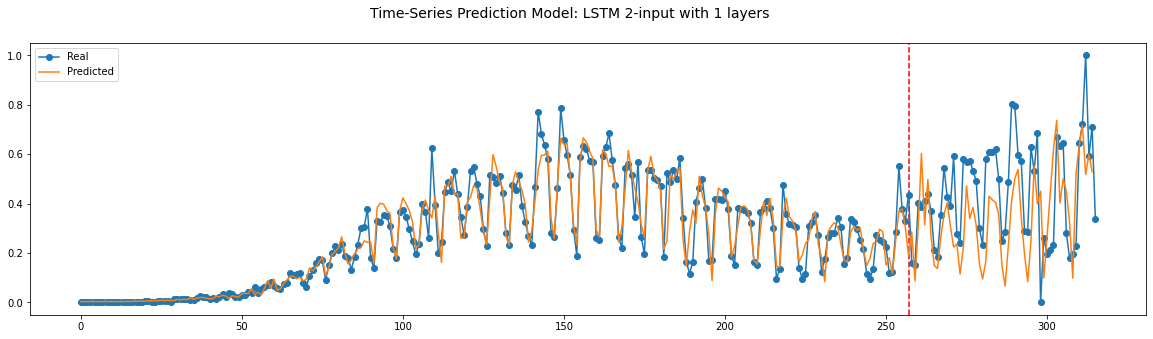

Epoch: 0, loss: 0.10163
Epoch: 500, loss: 0.00426
Epoch: 1000, loss: 0.00259
Epoch: 1500, loss: 0.00125


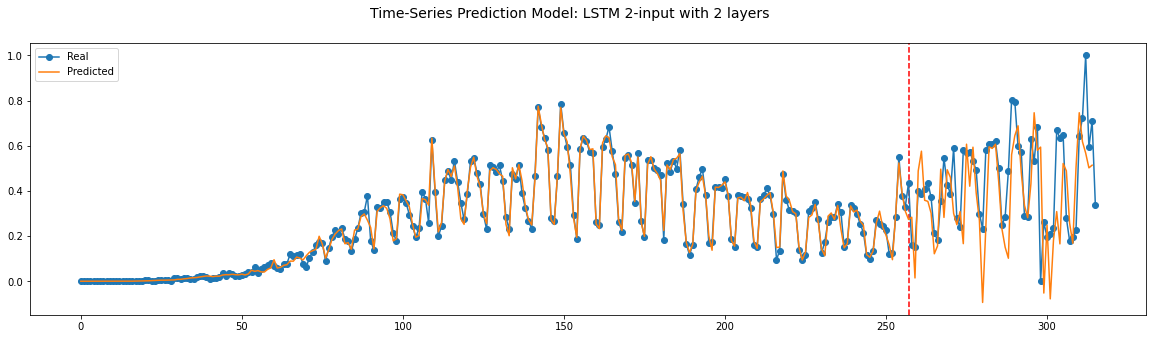

Epoch: 0, loss: 0.09723
Epoch: 500, loss: 0.00346
Epoch: 1000, loss: 0.00196
Epoch: 1500, loss: 0.00092


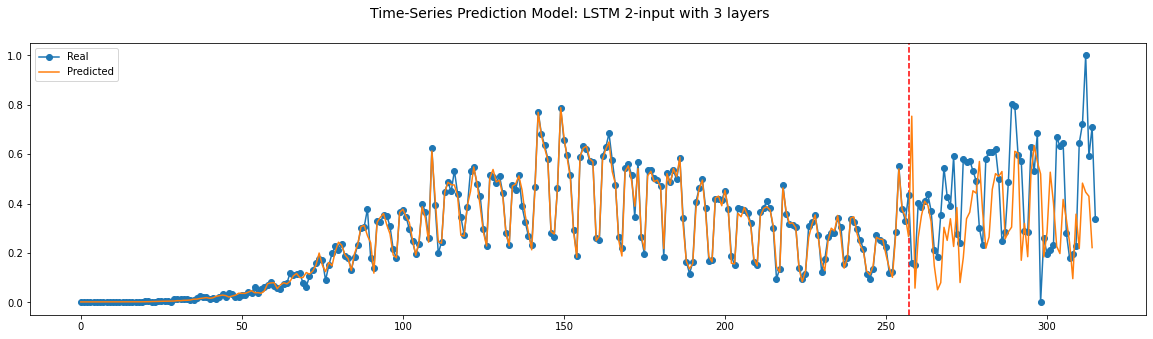

Epoch: 0, loss: 0.07270
Epoch: 500, loss: 0.00455
Epoch: 1000, loss: 0.00248
Epoch: 1500, loss: 0.00136


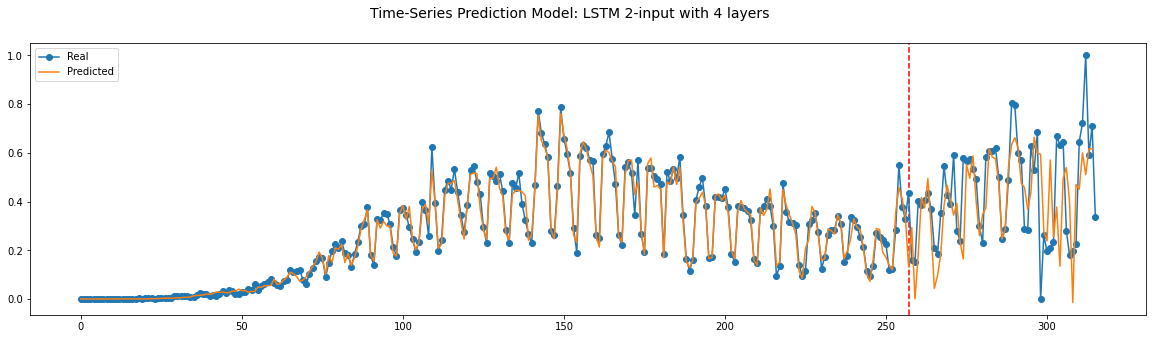

In [37]:
num_epochs = 2000
learning_rate = 0.01

input_size = 2 # input size!!! agora com duas séries de entrada
hidden_size = 6

for num_layers in range(1,5):

  # num_layers = 1, 2, 3, 4

  model = LSTM(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, trainX, trainY)

  model.eval()
  prediction = model(x.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: LSTM 2-input with {num_layers} layers', fontsize=14)

  plt.savefig('plot_lstm2_' + str(num_layers) + '_layers.png')
  plt.show()

# Empregando uma `RNN` 

No lugar de uma LSTM podemos também empregar uma rede neural recorrente pura. É o que fazemos abaixo. Antes, reestabelecemos os dados para fazer a previsão à partir de uma uma única sequencia de dados de entrada.

In [38]:
# salvando os dados com uma única série de dados 
x, y, trainX, trainY, testX, testY = x1, y1, trainX1, trainY1, testX1, testY1   

In [39]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, h_out = self.rnn(x)                  # dois parâmetros e não três como na lstm
     
        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)  
        out_final = self.fc(h_out)

        return out_final

Epoch: 0, loss: 0.13229
Epoch: 500, loss: 0.00606
Epoch: 1000, loss: 0.00562
Epoch: 1500, loss: 0.00475


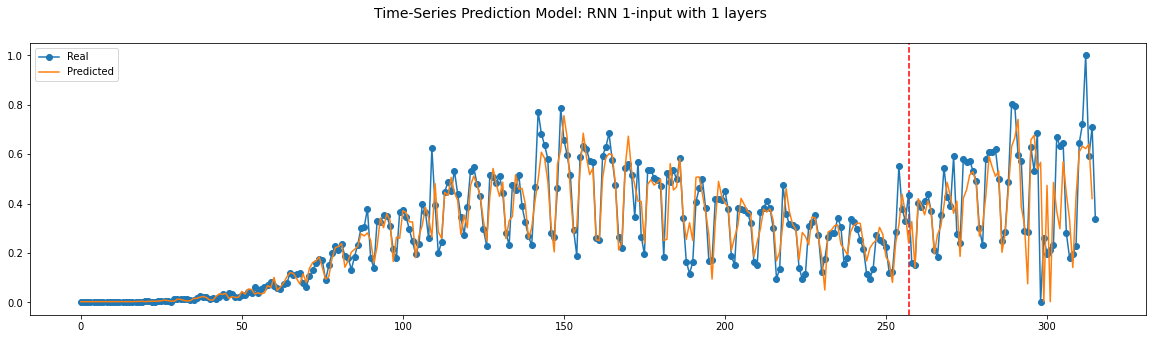

Epoch: 0, loss: 0.06892
Epoch: 500, loss: 0.00578
Epoch: 1000, loss: 0.00479
Epoch: 1500, loss: 0.00400


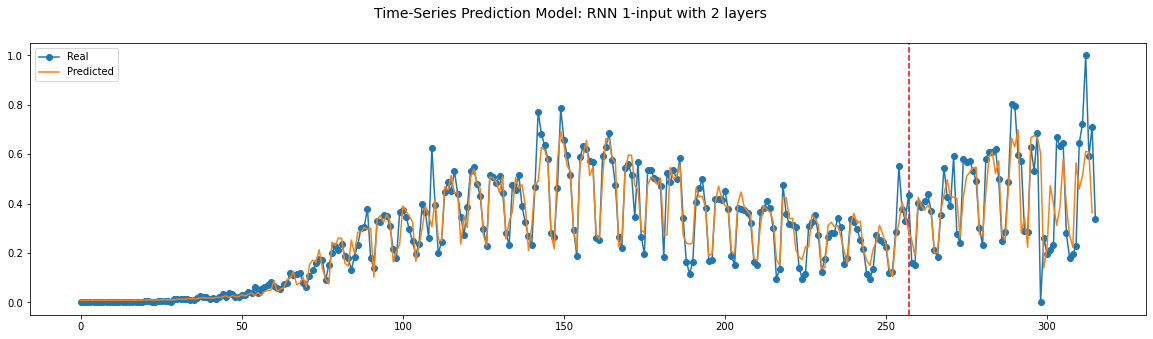

Epoch: 0, loss: 0.04028
Epoch: 500, loss: 0.00421
Epoch: 1000, loss: 0.00254
Epoch: 1500, loss: 0.00115


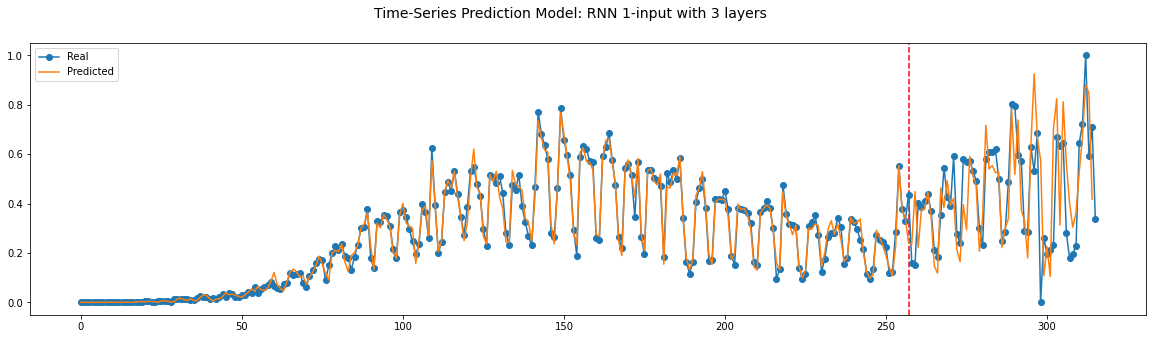

Epoch: 0, loss: 1.39093
Epoch: 500, loss: 0.00580
Epoch: 1000, loss: 0.00477
Epoch: 1500, loss: 0.00425


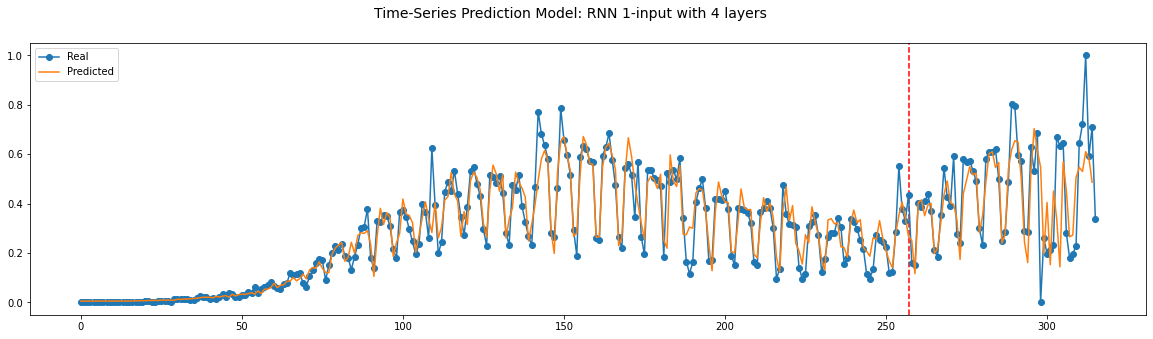

In [40]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! agora com duas séries de entrada
hidden_size = 6

for num_layers in range(1,5):

  # num_layers = 1, 2, 3, 4

  model = RNN(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, trainX, trainY)

  model.eval()
  prediction = model(x.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: RNN 1-input with {num_layers} layers', fontsize=14)
  
  plt.savefig('plot_rnn1_' + str(num_layers) + '_layers.png')
  plt.show()

# Resultados 

Aqui os gráficos de predição para os 3 modelos com 4 camadas.

* LSTM 1-input, 4-layers
* LSTM 2-input, 4-layers
* RNN 1-input, 4-layers


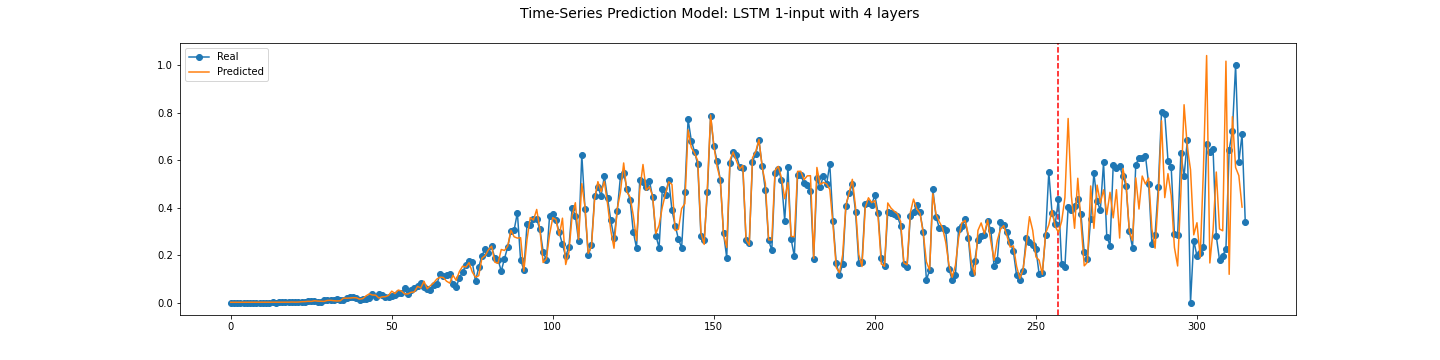

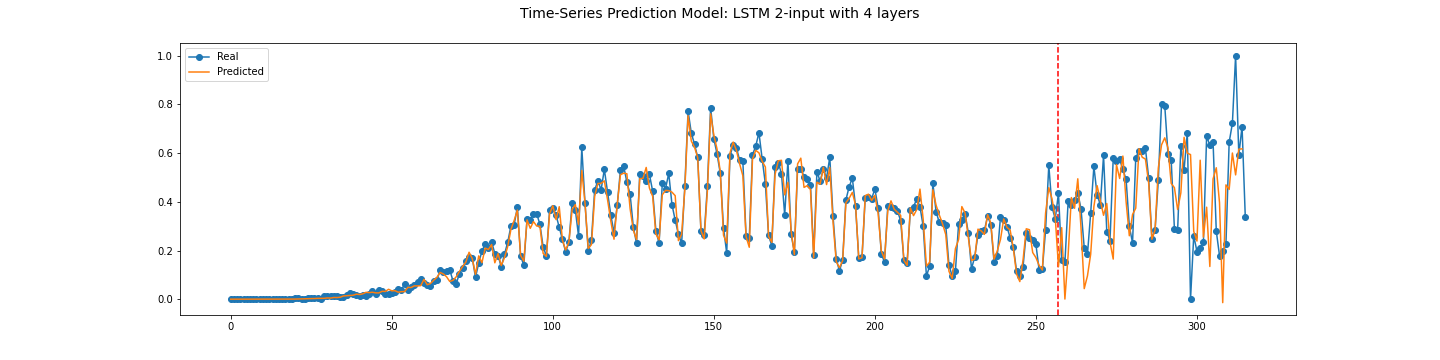

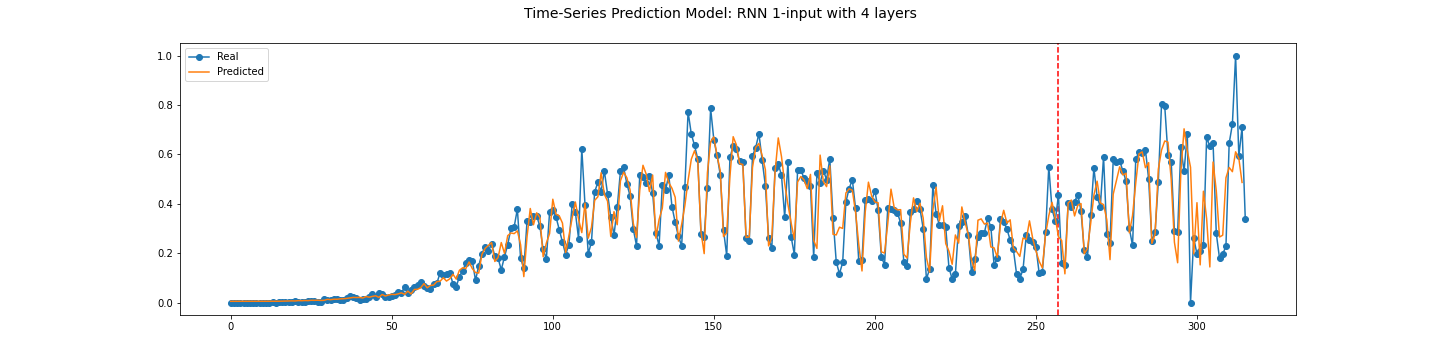

In [41]:
from IPython.display import Image, display
display(Image('/content/plot_lstm1_4_layers.png'))
display(Image('/content/plot_lstm2_4_layers.png'))
display(Image('/content/plot_rnn1_4_layers.png'))